### Business Understanding

Onderzoeksvraag:
Kan er een voorspelling worden gedaan over de vertragingstijd om treinverkeersleiders efficiënter de treinplanning te hervatten.




-------------------------------------

### Data Understanding
Van ProRail hebben we een [data dictionary](https://canvas.hu.nl/courses/27143/pages/data?module_item_id=588747) gekregen.
Hierin staan alle kolommen in uit de dataset met een beschrijving over de kolom indien van toepassing.

We beginnen met een aantal modules te importeren om de data te analyseren.

In [2]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor


import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", 100)

pd.options.display.max_columns = None
pd.options.display.max_rows = 1000

%matplotlib inline

Dataset inladen

In [3]:
dataset_complete = pd.read_csv("sap_storing_data_hu_project.csv", low_memory=False)

In [4]:
# todo later verwijderen en hele dataset pakken
# 10% (1 jaar +- aan datapunten) van data inladen is tijdelijk, om efficiënter te werk te gaan tijdens de onderzoek fase
ten_percent = int(dataset_complete.shape[0]*.1)
dataset = dataset_complete.sample(ten_percent, random_state=0)

We bekijken de eerste paar rijen om een eerste inzicht te krijgen over de daadwerkelijke data.

In [ ]:
dataset.head()

Bekijken van het aantal datapunten en kolommen in de data.

In [6]:
rows, cols = dataset.shape
print(f'De dataset bevat {rows} rijen en {cols} kolommen')

De dataset bevat 89852 rijen en 140 kolommen


#### Interessante kolommen om de target variabele te construeren.
We gaan eerst de kolommen analyseren die mogelijk van toepassing kunnen zijn bij het bepalen van een target variabele voor de onderzoeksvraag.

Hiervoor gebruiken we het tijdstip van de functieherstel.
Functieherstel tijdstip is het moment dat een storing is opgelost, maar het treinverkeer nog niet per definitie hervat is.
De functieherstel duur is de tijd vanaf de initiële melding tot de tijdstip van functieherstel.

Volgens het interview met Pro Rail is het vaak lastig om te bepalen hoelang het duurt voordat een aanemer ter plaatse is om een storing te verhelpen.
Om deze reden is de duur van de complete storing (functieherstel duur) lastig te voorspellen. Daarom kijken we ook naar het tijd dat de aannemer ter plaatse is. De duur van dit tijdstip tot het tijdstip van de functieherstel tijd is interessant om te onderzoeken omdat vanaf het moment dat de aannemer aanwezig is er **waarschijnlijk** meer te zeggen valt over hoelang de vertraging nog duurt.

Ook heeft Pro Rail ons laten weten dat ze het vooral interessant vinden om storingen te bekijken/voorspellen die niet langer duren dan een werkdag.

Voor de meld, aannemer ter plaatse en functieherstel tijd zijn 2 verschillende kolommen aanwezig in de data dictionary laten we ze allemaal bekijken om het verschil te zien.

In [7]:
target_selection = ['stm_sap_meldtijd','stm_sap_meld_ddt', 'stm_aanntpl_tijd', 'stm_aanntpl_ddt', 'stm_fh_tijd', 'stm_fh_ddt', 'stm_fh_duur']

In [8]:
dataset[target_selection].head(10)

,stm_sap_meldtijd,stm_sap_meld_ddt,stm_aanntpl_tijd,stm_aanntpl_ddt,stm_fh_tijd,stm_fh_ddt,stm_fh_duur
592816,14:10:00,12/01/2014 14:10:00,09:50:00,13/01/2014 09:50:00,10:29:00,13/01/2014 10:29:00,1219.0
680751,17:32:00,30/01/2015 17:32:00,18:46:00,30/01/2015 18:46:00,19:20:00,30/01/2015 19:20:00,108.0
760628,08:25:04,20/04/2016 08:25:04,08:25:39,20/04/2016 08:25:39,12:20:48,20/04/2016 12:20:48,236.0
237571,10:23:00,06/08/2006 10:23:00,11:27:00,06/08/2006 11:27:00,12:19:00,06/08/2006 12:19:00,116.0
849077,11:50:21,19/09/2017 11:50:21,13:00:01,19/09/2017 13:00:01,13:34:00,19/09/2017 13:34:00,104.0
679491,05:20:00,25/01/2015 05:20:00,23:45:00,25/01/2015 23:45:00,00:15:00,26/01/2015 00:15:00,1135.0
341653,18:02:00,10/04/2009 18:02:00,21:00:00,11/04/2009 21:00:00,21:15:00,11/04/2009 21:15:00,1633.0
304567,10:21:00,06/05/2008 10:21:00,12:01:00,06/05/2008 12:01:00,12:07:00,06/05/2008 12:07:00,104.0
515604,09:43:00,01/03/2013 09:43:00,09:47:00,01/03/2013 09:47:00,09:54:00,01/03/2013 09:54:00,11.0
498789,10:44:00,30/12/2012 10:44:00,11:55:00,30/12/2012 11:55:00,14:50:00,30/12/2012 14:50:00,244.0



Opvallend is dat de functieherstel duur in veel gevallen aanzienlijk langer is dan de duur tussen het tijdstip dat de aannemer ter plaatse is en het functieherstel tijdstip.

De kolommen eindigend op ddt bevatten een datum en tijd in Dag:Maand:Jaar Uur:Minuten:Seconden.
En de kolommen eindigend op tijd bevatten alleen de tijd in Uur:Minuten:Seconden.

Wat ook opvalt is dat de kolommen eindigend met ddt NaN waardes bevat maar op eerste blik alleen bij rijen waar de functieherstel duur 0 is of wanneer de aannemer ter plaatse tijd 00:00:00 is. Dit duidt er op dat NaN waardes die altijd gecombineerd lijken te zijn met een tijdstip 00:00:00 alleen in rijen voorkomt waar er geen aannemer ter plaatse nodig was om de storing te verhelpen

### Meetniveau

De target variabele kolom is nog niet aanwezig maar dit zal in dezelfde eenheid zijn als functieherstel duur namelijk, duur in minuten.

Minuten zijn van een continue meetniveau omdat je tot oneindige precisie tussen 2 verschillende waardes in minuten kan meten.

In [9]:
dataset['stm_fh_duur'].describe().round()

count     89851.0
mean        936.0
std        6510.0
min           0.0
25%          11.0
50%          83.0
75%         256.0
max      525621.0
Name: stm_fh_duur, dtype: float64

In de tabel hierboven is te zien:
- Aantal observaties
- Gemiddelde
- Minimale observatie
- 25% (Kwartiel 1)
- 50% (Kwartiel 2, ookwel de mediaan)
- 75% (Kwartiel 3)
- Maximale observatie

We kunnen hier uit een aantal dingen opmerken:
- Groot verschil tussen min en max observaties.
- Het gemiddelde ligt veel hoger dan de mediaan, dit duidt op uitschieters.
- Minimale observatie is 0, dit zouden storingen kunnen zijn die niet voor vertraging zorgen (zoals een ICT storing).
- Grote standaard deviatie, dit duidt er op dat de observaties breedt verdeelt zijn om het gemiddelde.

Om een visuele blik te krijgen op de verdeling van de data plotten we een histogram.

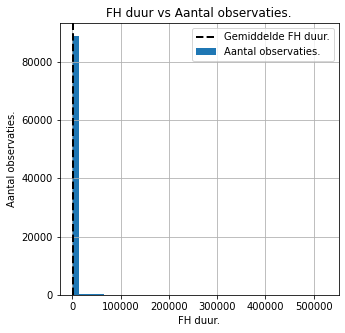

In [10]:
dataset[target_selection].hist(figsize=(5,5), bins=40) # hist
plt.axvline(dataset['stm_fh_duur'].mean(), color='black', linestyle='dashed', linewidth=2) # add mean line
plt.legend(["Gemiddelde FH duur.", "Aantal observaties."], loc="upper right") # legend
plt.title("FH duur vs Aantal observaties."), plt.xlabel("FH duur."), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

Zoals te zien en omschreven bij de describe is de FH duur erg verspreidt en bevat outliers die de histogram onleesbaar maakt.

Laten we daarom opnieuw een histogram plotten die alleen naar storingen kijkt die binnen één werkdag (8 uur, 480 minuten) zijn opgelost en die voor een vertraging hebben gezorgd (FH duur groter zijn dan 0). Ook omdat dit de meest interessante storingen zijn om mogelijk een voorspellingen over te kunnen doen volgens Pro Rail.

In [11]:
zero_360_filter = (dataset['stm_fh_duur'] > 0) & (
            dataset['stm_fh_duur'] <= 360)  # boolean mask to filter on FH > 0 and <= 360.

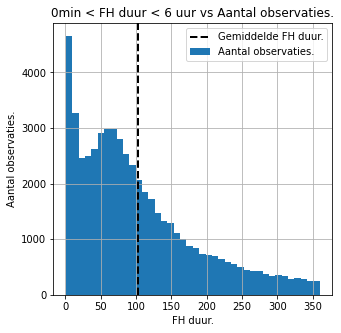

In [12]:
dataset[zero_360_filter][target_selection].hist(figsize=(5,5), bins = 40)# hist
plt.axvline(dataset[zero_360_filter]['stm_fh_duur'].mean(), color='black', linestyle='dashed', linewidth=2) # add mean line
plt.legend(["Gemiddelde FH duur.", "Aantal observaties."], loc="upper right") # legend
plt.title("0min < FH duur < 6 uur vs Aantal observaties."), plt.xlabel("FH duur."), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

FH duur boven de 0 minuten en tot en met 6 uur, heeft een rechtscheve verdeling. #todo check correct distribution

## #todo vanaf hier lui geweest met tekst

#### Uitschieters

Om een visueel beeld te krijgen van de spreiding/uitschieters van de functieherstel duur wordt deze getoond in een boxplot.

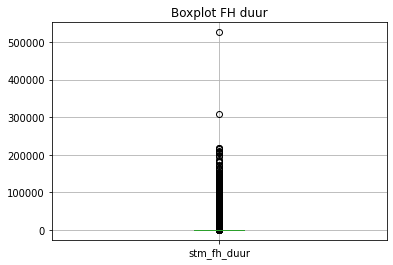

In [13]:
dataset.boxplot('stm_fh_duur')
plt.title("Boxplot FH duur")
plt.show()

Er zijn veel extreem hoge uitschieters terwijl het mediaan laag ligt.
Om een beter overzicht te krijgen kijken we in een nieuwe boxplot alleen naar functieherstel duur boven de 0 en onder de 360 minuten.

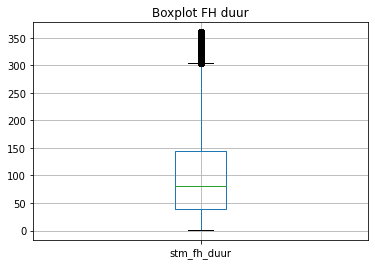

In [14]:
dataset[zero_360_filter].boxplot('stm_fh_duur')
plt.title("Boxplot FH duur")
plt.show()

Er lijken alleen uitschieters aan de rechter kant te zitten.
De maximale niet-uitschieter is ongeveer 300 minuten en de kleinste niet uitschieter 1 minuut.
De helft van de vertagingen tussen 1 en 360 minuten valt binnen ongeveer 45 en 150 minuten.

### Data Preparation
Nu de interessante kolommen om een target variabele te voorspellen zijn geanalyseerd kunnen ze worden opgeschoond om de target variabele te construeren.


In [176]:
df_target = dataset.copy()

##### NA waardes
Controleren NA values.

In [177]:
df_target[target_selection].isna().sum()

stm_sap_meldtijd    4
stm_sap_meld_ddt    0
stm_aanntpl_tijd    0
stm_aanntpl_ddt     0
stm_fh_tijd         0
stm_fh_ddt          0
stm_fh_duur         0
dtype: int64

Alleen de kolommen aannemer ter plaatse ddt en functie herstel duur ddt bevatten een merkwaardig aantal NaN waardes.
Laten we kijken hoeveel van deze NaN waardes overeen komen met een functieherstel tijd van 0 minuten. En ook hoeveel er overeen komen met een aannemer ter plaatse tijdstip van 00:00:00 omdat dit in de data understanding fase opviel.

In [178]:
(df_target['stm_aanntpl_tijd'] == '00:00:00').sum()

0

Bijna alle aannemer ter plaatse tijdstippen komen overeen met 00:00:00 waar der een NaN is voor de ddt variant van de kolom.

In [179]:
(df_target['stm_fh_duur'] == 0).sum()

0

In [180]:
df_target[target_selection] = df_target[target_selection].dropna()

##### Duplicate rijen
Aantal duplicate rijen controleren en verwijderen.

In [181]:
df_target.duplicated().sum()

0

In [182]:
df_target[target_selection] = df_target[target_selection].drop_duplicates()

##### Dtypes
Dtypes controleren

In [183]:
df_target[target_selection].dtypes

stm_sap_meldtijd            object
stm_sap_meld_ddt    datetime64[ns]
stm_aanntpl_tijd            object
stm_aanntpl_ddt     datetime64[ns]
stm_fh_tijd                 object
stm_fh_ddt          datetime64[ns]
stm_fh_duur                float64
dtype: object

We veranderen alle dtypes van tijd en datum kolommen naar een datetime object

In [184]:
ddt_cols = list(filter(lambda x: 'ddt' in x, dataset.columns)) # filter columns on containing 'ddt' in their name
df_target[ddt_cols] = df_target[ddt_cols].apply(lambda ddt_col: pd.to_datetime(ddt_col, format='%d/%m/%Y %H:%M:%S', errors='coerce')) # apply to_datetime to every ddt column

In [185]:
tijd_cols = list(filter(lambda x: 'tijd' in x, dataset.columns))
df_target[tijd_cols] = df_target[tijd_cols].apply(lambda tijd_col: pd.to_datetime(tijd_col,format= '%H:%M:%S', errors='coerce').dt.time)

In [186]:
df_target[target_selection].dtypes # note just the timestamp in H:M stay a object, but is workable now (like sorting and comparing)

stm_sap_meldtijd            object
stm_sap_meld_ddt    datetime64[ns]
stm_aanntpl_tijd            object
stm_aanntpl_ddt     datetime64[ns]
stm_fh_tijd                 object
stm_fh_ddt          datetime64[ns]
stm_fh_duur                float64
dtype: object

De benodigde kolommen hun dtypes zijn nu kloppend.
<br>
##### Uitschieters

Zoals eerder beschreven tijdens de data understanding fase heeft ProRail laten weten vooral geïnteresseerd te zijn in de vertragingen waarvan de oorzakende storing maximaal één werkdag lang is.

Daarom halen we alle rijen weg met een functieherstel duur van kleiner gelijk dan 360 minuten oftwel 6 uur.
Hiermee wordt gelijk een groot gedeelte van de uitschieters verwijderd.

In [187]:
df_target = df_target[(df_target['stm_fh_duur'] <= 360)]

Omdat niet elk model gevoelig is voor uitschieters laten we de uitschieters die er zijn na het verwijderen van alle rijen met een functie hersteltijd hoger dan 8 uur in de data zitten.
De overgebleven outliers worden behandeld indien nodig voor destbetreffend model tijdens de modellerings fase.

Ook worden alle rijen met een functieherstel tijd van 0 minuten verwijderd omdat dit geen vertragingen zijn.

In [188]:
df_target = df_target[(df_target['stm_fh_duur'] > 0)]

We willen als target bepalen de duur van aanntpl tijd tot fh tijd.
Het is handig om eerst te controleren of de aanntpl ddt altijd eerder is dan de fh ddt.

In [189]:
print(np.sum(df_target['stm_fh_ddt'] < df_target['stm_aanntpl_ddt']), 'Rijen waar de FH tijd eerder was dan de aannemer ter plaatse tijd')

0 Rijen waar de FH tijd eerder was dan de aannemer ter plaatse tijd


Laten we deze droppen omdat we voorspellingen willen doen over vertragingen waar een aannemer ter plaatse kwam voordat de functie hersteltijd was.

In [190]:
#df_target[df_target['stm_fh_ddt'] > df_target['stm_aanntpl_ddt']]

De data nodig om de target variabele is nu opgeschoond en kan nu worden aangemaakt.

In [191]:
df_target['aanntpl_fh_duur'] = ((df_target['stm_fh_ddt'] - df_target['stm_aanntpl_ddt']).dt.total_seconds() / 60).astype('int')

In [192]:
df_target['aanntpl_fh_duur']

680751     34
760628    235
237571     52
849077     33
304567      6
         ... 
372093     79
819633    109
482955      3
601257     35
490991      3
Name: aanntpl_fh_duur, Length: 46195, dtype: int32

Waardes verwijderen van 0 of lager door dat de functieherstel tijd in de data eerder was dan het tijdstip dat de aannemer ter plaatse kwam volgens de data.

In [153]:
#df_target = df_target[ ( df_target['aanntpl_fh_duur'] > 0 ) ]
#df_target = df_target[ ( df_target['aanntpl_fh_duur'] <= 360 ) ] # fix this at earlier stage.

##### Target variabele gemaakt en schoon.
Target variabele aantpl_fh_duur, de duur vanaf het moment dat de aannemer ter plaatse is tot de functieherstel tijd, is nu opgeschoond en de originele dataset kan worden gemerged. Om een nieuw dataframe te maken met alle kolommen maar alleen de rijen die zijn overgebleven na het huidige proces.

In [154]:
dataset = df_target

In [194]:
dataset['aanntpl_fh_duur']

680751     34
760628    235
237571     52
849077     33
304567      6
         ... 
372093     79
819633    109
482955      3
601257     35
490991      3
Name: aanntpl_fh_duur, Length: 46199, dtype: int32

### Modeling baseline

Het is belangrijk om een baseline te hebben. Dit is een rudimentaire voorspelling, die we als lat leggen voor onze andere modellen.
Omdat het meetniveau van de target variabele continue is wordt voor een uiteindelijk een regressie model gebruikt. Voor een baseline voor een regressie model kunnen we een centrummaat zoals het gemiddelde of de mediaan.

##### Het splitsen van de dataset
We splitsen de data op in een train- en testset.

In [195]:
target = 'aanntpl_fh_duur'
X = dataset.drop(target ,axis=1)
y = dataset[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### Baseline model maken en fitten

In [196]:
baseline = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

In [197]:
y_predict = baseline.predict(X_test)

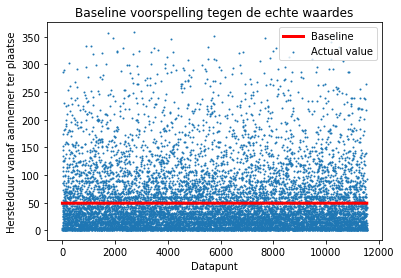

 RMSE Baseline model: 56


In [200]:
plt.plot(y_predict, c='r', linewidth=3)
plt.scatter(x=np.arange(len(X_test)), y=y_test, s=1)

plt.title("Baseline voorspelling tegen de echte waardes")
plt.xlabel("Datapunt")
plt.ylabel("Herstelduur vanaf aannemer ter plaatse")
plt.legend(["Baseline", "Actual value"], loc="upper right")
plt.show()

baseline_rmse = round(mean_squared_error(y_test, y_predict, squared=False))
print(f" RMSE Baseline model: {baseline_rmse}")

De te implementeren modellen kunnen we vergelijken met deze score om zo te bepalen of hij beter is dat het baseline model en zo ja, in welke maten?

#### Vanaf hier de benodigde CRISP-DM stappen opnieuw doorlopen voor het eerste model.

### Data understanding model 1

In [39]:
for col in list(filter(lambda x: 'progfh' and 'ddt' in x, dataset.columns)):
    print(round((np.sum(dataset['stm_aanntpl_ddt'] > dataset[col])/dataset.shape[0])*100), col)

99 stm_sap_meld_ddt
97 stm_sap_mon_meld_ddt
23 stm_mon_begin_ddt
99 stm_aanngeb_ddt
0 stm_aanntpl_ddt
1 stm_progfh_in_ddt
2 stm_progfh_in_invoer_ddt
1 stm_progfh_gw_ddt
1 stm_progfh_gw_lwd_ddt
5 stm_afspr_aanvangddt
0 stm_fh_ddt
0 stm_sap_storeind_ddt
5 stm_mon_eind_ddt
0 stm_afsluit_ddt
84 stm_rec_toegev_ddt


In [210]:
dataset[(round((dataset['stm_progfh_in_invoer_ddt']-dataset['stm_aanntpl_ddt']).dt.total_seconds()/60) > 0)][['stm_fh_ddt','stm_progfh_in_invoer_ddt','stm_aanntpl_ddt', target, 'EIGEN_aanntpl_fh_duur_prog']]

,stm_fh_ddt,stm_progfh_in_invoer_ddt,stm_aanntpl_ddt,aanntpl_fh_duur,EIGEN_aanntpl_fh_duur_prog
680751,2015-01-30 19:20:00,2015-01-30 19:21:50,2015-01-30 18:46:00,34,59.0
237571,2006-08-06 12:19:00,2006-08-06 11:29:29,2006-08-06 11:27:00,52,60.0
849077,2017-09-19 13:34:00,2017-09-19 13:33:37,2017-09-19 13:00:01,33,10111.0
304567,2008-05-06 12:07:00,2008-05-06 12:02:08,2008-05-06 12:01:00,6,0.0
515604,2013-03-01 09:54:00,2013-03-01 10:00:01,2013-03-01 09:47:00,7,5.0
...,...,...,...,...,...
626157,2014-05-13 17:30:00,2014-05-13 17:40:11,2014-05-13 17:25:00,5,35.0
372093,2010-01-06 20:45:00,2010-01-06 19:27:46,2010-01-06 19:26:00,79,151.0
482955,2012-08-05 20:27:00,2012-08-05 20:27:54,2012-08-05 20:24:00,3,1446.0
601257,2014-02-12 17:35:00,2014-02-12 17:34:44,2014-02-12 17:00:00,35,45.0


In [218]:
np.sum(dataset['stm_fh_ddt'] < dataset['stm_progfh_in_invoer_ddt'])

11558

Een groter deel van de prognose invoer tijden zijn ingevuld nadat de functiehersteltijd

In [41]:
dataset.shape[0]

46199

In [236]:
dataset[(dataset['EIGEN_fh_duur_prog']>0) & (dataset['EIGEN_fh_duur_prog']<360*4)][['stm_progfh_in_duur', 'EIGEN_aanntpl_fh_duur_prog','EIGEN_aanttpl_fh_duur','stm_fh_duur', 'EIGEN_fh_duur_prog', 'stm_aanntpl_ddt','stm_progfh_in_ddt', 'stm_progfh_in_datum', 'stm_progfh_in_tijd']]
#['stm_progfh_in_duur', 'stm_fh_duur', 'duur', 'aanntpl_fh_duur', 'duur_aanntpl_prog', 'stm_aanntpl_ddt','stm_fh_ddt']

,stm_progfh_in_duur,EIGEN_aanntpl_fh_duur_prog,EIGEN_aanttpl_fh_duur,stm_fh_duur,EIGEN_fh_duur_prog,stm_aanntpl_ddt,stm_progfh_in_ddt,stm_progfh_in_datum,stm_progfh_in_tijd
680751,59,59.0,34,108.0,133.0,2015-01-30 18:46:00,2015-01-30 19:45:00,30/01/2015,19:45:00
237571,60,60.0,52,116.0,124.0,2006-08-06 11:27:00,2006-08-06 12:27:00,06/08/2006,12:27:00
304567,0,0.0,6,104.0,100.0,2008-05-06 12:01:00,2008-05-06 12:01:00,06/05/2008,12:01:00
515604,5,5.0,7,11.0,9.0,2013-03-01 09:47:00,2013-03-01 09:52:00,01/03/2013,09:52:00
498789,185,185.0,175,244.0,256.0,2012-12-30 11:55:00,2012-12-30 15:00:00,30/12/2012,15:00:00
...,...,...,...,...,...,...,...,...,...
626157,35,35.0,5,8.0,39.0,2014-05-13 17:25:00,2014-05-13 18:00:00,13/05/2014,18:00:00
768115,70,70.0,39,99.0,130.0,2016-05-19 01:20:00,2016-05-19 02:30:00,19/05/2016,02:30:00
372093,151,151.0,79,195.0,269.0,2010-01-06 19:26:00,2010-01-06 21:57:00,06/01/2010,21:57:00
601257,45,45.0,35,74.0,84.0,2014-02-12 17:00:00,2014-02-12 17:45:00,12/02/2014,17:45:00


In [228]:
dataset['EIGEN_fh_duur_prog'] = round(((dataset['stm_progfh_in_ddt'] - dataset['stm_sap_meld_ddt']).dt.total_seconds()/60))
dataset['EIGEN_aanntpl_fh_duur_prog'] = round(((dataset['stm_progfh_in_ddt'] - dataset['stm_aanntpl_ddt']).dt.total_seconds()/60))
dataset['EIGEN_aanttpl_fh_duur'] = dataset[target]
# ZELFDE ALS STM PROG FH IN DUUR

# FH DUUR prognose = prognose DDT - Melding DDT
# FH DUUR prognose vanaf aanntpl = prognose DDT - aanntpl DDT
# FH DUUR vanaf aanntpl = FunctieHerstel DDT - aanntpl DDT

# Conclusies uit bovenstaande tabel:
# 1. stm_progfh_in_duur is *meestal* de FH Duur prognose vanaf aanntpl anders de totale FH Duur prognose
# 2. Prognoses zijn soms negatief of 0 (geen geldige prognose!)
# 3. Er zijn positieve prognoses ver, ver van de daadwerkelijke tijd afzitten bijv:
#                                                                                  FH duur van 235, Prognose van 4122860
# Omdat we ons vooral focussen op het voorspellen van 'korte' vertragingen, Alles met een prognose van < 360 weg?

In [60]:
dataset['stm_sap_meld_ddt'].describe()

<ipython-input-60-d94779b304e3>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dataset['stm_sap_meld_ddt'].describe()


count                   46199
unique                  45927
top       2014-02-24 21:08:00
freq                        3
first     2006-01-02 09:19:46
last      2019-07-09 03:07:25
Name: stm_sap_meld_ddt, dtype: object

In [146]:
t[[target, 'EIGEN_aanntpl_fh_duur_prog', 'EIGEN_fh_duur_prog', 'stm_fh_duur']]

,aanntpl_fh_duur,EIGEN_aanntpl_fh_duur_prog,EIGEN_fh_duur_prog,stm_fh_duur
680751,34,59.0,133.0,108.0
237571,52,60.0,124.0,116.0
849077,33,10111.0,10181.0,104.0
304567,6,0.0,100.0,104.0
515604,7,5.0,9.0,11.0
...,...,...,...,...
768115,39,70.0,130.0,99.0
372093,79,151.0,269.0,195.0
482955,3,1446.0,1477.0,34.0
601257,35,45.0,84.0,74.0


In [145]:
t = dataset[[target, 'EIGEN_aanntpl_fh_duur_prog', 'EIGEN_fh_duur_prog', 'stm_fh_duur']].dropna().copy()

In [141]:
t[['EIGEN_aanntpl_fh_duur_prog']]

,EIGEN_aanntpl_fh_duur_prog
680751,59.0
237571,60.0
515604,5.0
498789,185.0
345916,70.0
...,...
626157,35.0
768115,70.0
372093,151.0
601257,45.0


In [140]:
t[(t['EIGEN_fh_duur_prog'] < 360) & (t['EIGEN_fh_duur_prog'] > 0)]['EIGEN_aanntpl_fh_duur_prog']

680751     59.0
237571     60.0
515604      5.0
498789    185.0
345916     70.0
          ...  
626157     35.0
768115     70.0
372093    151.0
601257     45.0
490991     15.0
Name: EIGEN_aanntpl_fh_duur_prog, Length: 33855, dtype: float64

In [134]:
t['EIGEN_aanntpl_fh_duur_prog']

680751     59.0
237571     60.0
515604      5.0
498789    185.0
345916     70.0
          ...  
626157     35.0
768115     70.0
372093    151.0
601257     45.0
490991     15.0
Name: EIGEN_aanntpl_fh_duur_prog, Length: 33855, dtype: float64

In [133]:
dataset[abs(dataset['fh_duur_prog']) < 360][dataset['aanntpl_fh_duur_prog'].notna()][['stm_progfh_in_duur', 'aanntpl_fh_duur_prog','aanntpl_fh_duur','stm_fh_duur', 'fh_duur_prog', 'stm_aanntpl_ddt','stm_progfh_in_ddt','stm_sap_meld_ddt', 'stm_progfh_in_invoer_ddt']]

KeyError: 'fh_duur_prog'

In [70]:
t['fh_duur_prog']<360
t.sort_values(by='fh_duur_prog', ascending=False).head(400)

KeyError: 'fh_duur_prog'

In [132]:
t = dataset[(abs(dataset['EIGEN_fh_duur_prog']) < 360)& (dataset['EIGEN_aanntpl_fh_duur_prog']>0) & (dataset['EIGEN_fh_duur_prog']>0)]
t=t[dataset['EIGEN_aanntpl_fh_duur_prog'].notna()]

# fh prognose moet onder 360 en boven 0 zijn en prognose vanaf aannemer ter plaatse > 0

<ipython-input-132-53fcb2273aca>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  t=t[dataset['EIGEN_aanntpl_fh_duur_prog'].notna()]


In [131]:
t[['stm_progfh_in_duur', 'aanntpl_fh_duur_prog','aanntpl_fh_duur','stm_fh_duur', 'fh_duur_prog', 'stm_aanntpl_ddt','stm_progfh_in_ddt','stm_sap_meld_ddt', 'stm_progfh_in_invoer_ddt']]


KeyError: "['fh_duur_prog', 'aanntpl_fh_duur_prog'] not in index"

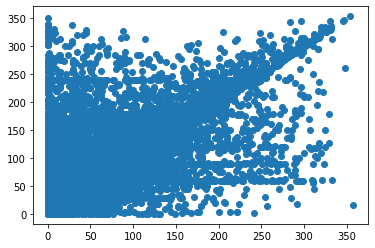

In [93]:
X = t[[target,'EIGEN_aanntpl_fh_duur_prog']].values
plt.scatter(X[:,0], X[:,1])

In [94]:
t[[target,'EIGEN_aanntpl_fh_duur_prog']].corr()

,aanntpl_fh_duur,EIGEN_aanntpl_fh_duur_prog
aanntpl_fh_duur,1.000000,0.748159
EIGEN_aanntpl_fh_duur_prog,0.748159,1.000000


## FM

In [147]:
dataset_m1 = t.copy()

In [96]:
features_selection = ['EIGEN_aanntpl_fh_duur_prog']#,'stm_prioriteit', 'stm_oorz_groep','stm_techn_gst', 'stm_oorz_code']

In [87]:
dataset_m1 = dataset_m1[[*features_selection, target]].copy()

In [ ]:

dataset_m1[['stm_prioriteit','stm_oorz_groep','stm_techn_gst', 'stm_oorz_code']] = dataset_m1[['stm_prioriteit','stm_oorz_groep','stm_techn_gst', 'stm_oorz_code']].astype('category')

In [148]:
dataset_m1_features = pd.get_dummies(dataset_m1[features_selection])

In [149]:
X = dataset_m1_features
y = t[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [150]:
depths = np.arange(1, 10)

In [151]:
rmse_scores = [mean_squared_error(y_test, DecisionTreeRegressor(max_depth=depth, random_state=0).fit(X_train, y_train).predict(X_test), squared=False) for depth in depths]
rmse_scores_train = [mean_squared_error(y_train, DecisionTreeRegressor(max_depth=depth, random_state=0).fit(X_train, y_train).predict(X_train), squared=False) for depth in depths]

Laagste RMSE bij regression tree: 39.34


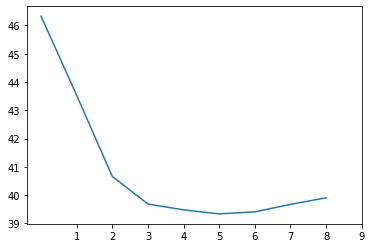

RMSE van prognose vs daadwerkelijke hersteltijd 312878.91941536963
RMSE Baseline:  56


In [152]:
plt.plot(rmse_scores)
#plt.plot(rmse_scores_train)

plt.xticks(depths)
print(f"Laagste RMSE bij regression tree: {round(min(rmse_scores),2)}")
plt.show()

p = t[['aanntpl_fh_duur', 'EIGEN_aanntpl_fh_duur_prog']].copy().dropna()
print("RMSE van prognose vs daadwerkelijke hersteltijd",mean_squared_error(p['aanntpl_fh_duur'],p['EIGEN_aanntpl_fh_duur_prog'], squared=False))
print("RMSE Baseline: ",baseline_rmse)